# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [9]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [10]:
data = pd.read_parquet("../data//train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

and in particular the number of unique entries in each column,

In [12]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

Let's look at the period of time the study was conducted on:

In [13]:
start = min(data["date"])
end = max(data["date"])
duration = (end-start).days

print(f"The study was conducted from {start.month_name()} {start.year} "
      f"to {end.month_name()} {end.year}.\n"
      f"This corresponds to {duration} days.")

The study was conducted from September 2020 to September 2021.
This corresponds to 373 days.


In [14]:
end

Timestamp('2021-09-09 23:00:00')

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [15]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\augus\AppData\Local\Temp\ipykernel_28476\1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [16]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

ModuleNotFoundError: No module named 'folium'

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

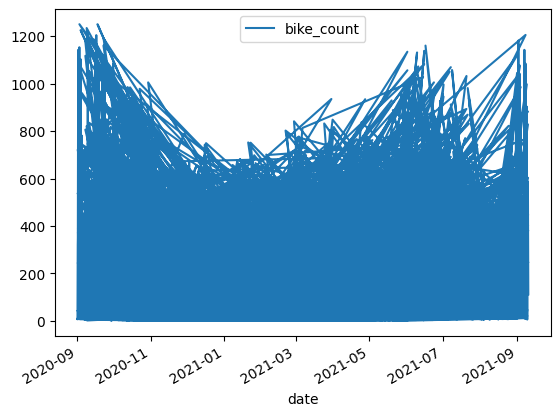

In [17]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

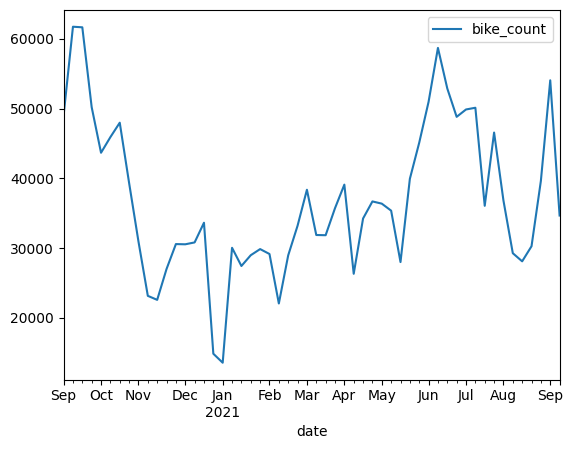

In [18]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1W", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

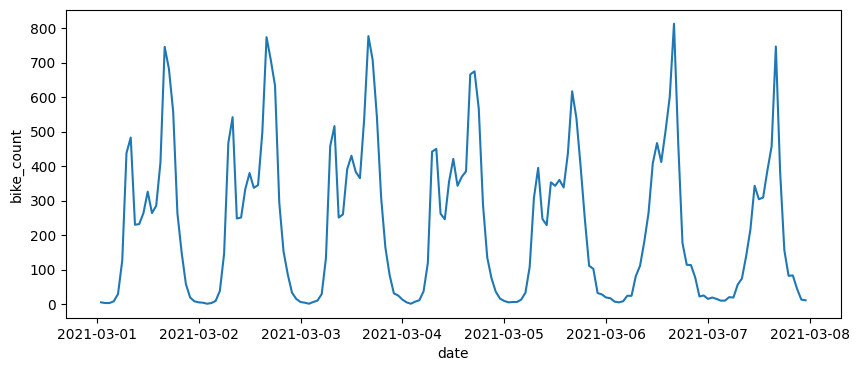

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

# data[mask].plot(x="date", y="bike_count", ax=ax)
sns.lineplot(data[mask], x="date", y="bike_count", ax=ax);

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

Let's also take a look at the average hourly traffic globally and for a given counter:

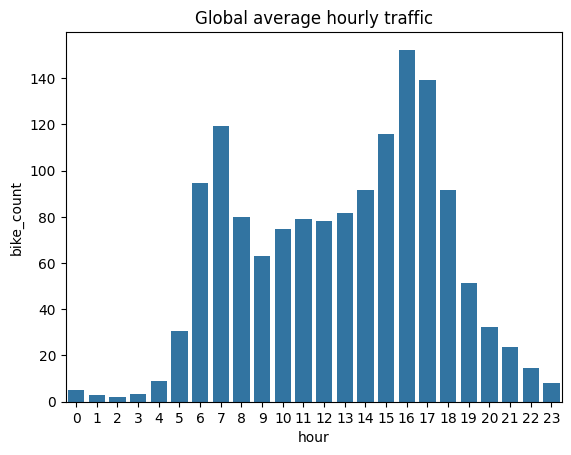

In [20]:
data["hour"] = data["date"].dt.hour

avg_hourly_traffic = data.groupby("hour").agg({"bike_count" : "mean"})
sns.barplot(avg_hourly_traffic, x="hour", y="bike_count")
plt.title("Global average hourly traffic")
plt.show()

data.drop(columns = "hour", inplace=True)

We can see 2 peaks, probably corresponding to travels from home to work and back. As expected, bike traffic is much lower during the night than during the day.

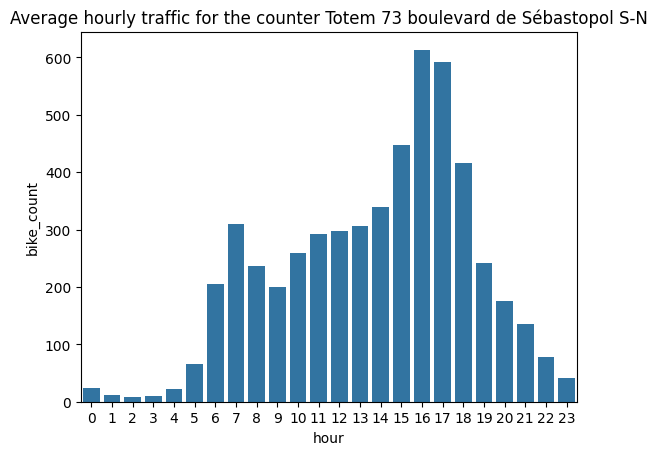

In [21]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data["hour"] = data["date"].dt.hour
avg_hourly_traffic_counter = data[mask].groupby("hour").agg({"bike_count" : "mean"})

sns.barplot(avg_hourly_traffic_counter, x="hour", y="bike_count")
plt.title("Average hourly traffic for the counter Totem 73 boulevard de Sébastopol S-N")
plt.show()

data.drop(columns = "hour", inplace=True)

We find a similar distribution of the traffic.

If we look at the distribution of the target variable it skewed and non normal, 


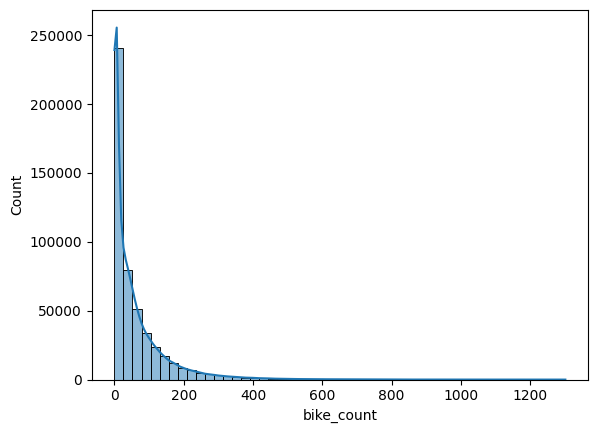

In [22]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

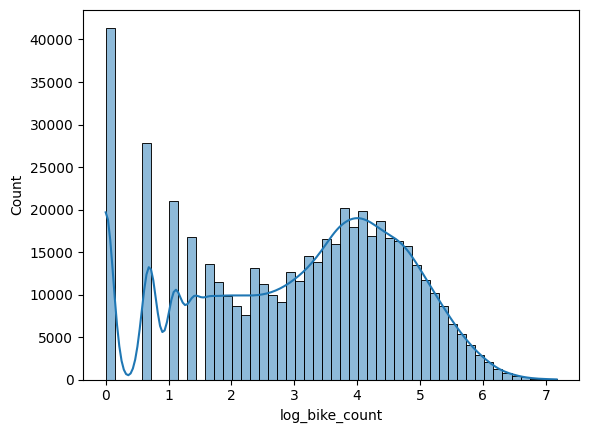

In [23]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [24]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [25]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [26]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [27]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [28]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [29]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


and

In [30]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [31]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [32]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [33]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000016047532520>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [35]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


c:\Users\augus\.virtualenvs\Python_classes-9Axu7pbz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\augus\.virtualenvs\Python_classes-9Axu7pbz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [36]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


c:\Users\augus\.virtualenvs\Python_classes-9Axu7pbz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\augus\.virtualenvs\Python_classes-9Axu7pbz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [37]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

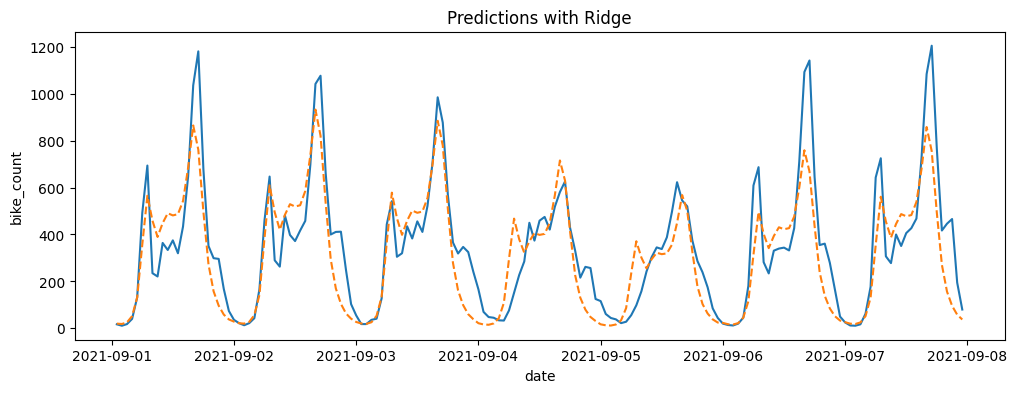

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_viz, x="date", y="bike_count", ax=ax)
sns.lineplot(df_viz, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

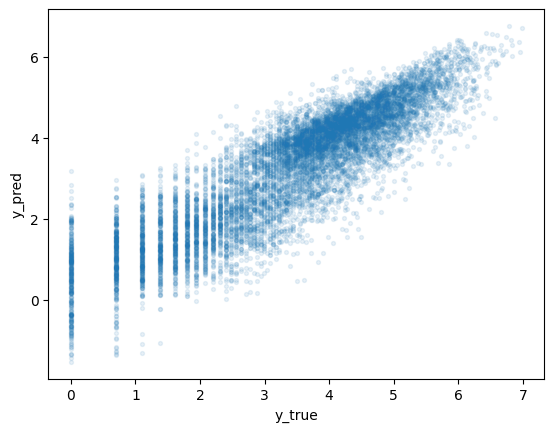

In [39]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [40]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370992 -0.87155645 -0.85104495 -0.87402961 -1.06387311 -0.96757067]
RMSE (all folds): 0.932 ± 0.0744


## Weather data analysis

### Dataset 1

In [41]:
weather = pd.read_csv("../external_data/external_data.csv")

weather["date"] = pd.to_datetime(weather["date"])

In [42]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numer_sta  3322 non-null   int64         
 1   date       3322 non-null   datetime64[ns]
 2   pmer       3322 non-null   int64         
 3   tend       3322 non-null   int64         
 4   cod_tend   3322 non-null   int64         
 5   dd         3322 non-null   int64         
 6   ff         3322 non-null   float64       
 7   t          3322 non-null   float64       
 8   td         3322 non-null   float64       
 9   u          3322 non-null   int64         
 10  vv         3322 non-null   int64         
 11  ww         3322 non-null   int64         
 12  w1         3315 non-null   float64       
 13  w2         3312 non-null   float64       
 14  n          3166 non-null   float64       
 15  nbas       3317 non-null   float64       
 16  hbas       2869 non-null   float64       


In [43]:
weather.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


We have 
- $3322$ observations
- $59$ columns

In the bike data, we had $496 827$ obserations. This means we have to figure out a way to merge the weather data with the bike data (indeed, the bike_counters do not measure the weather and count the bikes at the same time).

In [44]:
start = min(weather["date"])
end = max(weather["date"])
duration = (end-start).days

print(f"The study was conducted from {start.month_name()} {start.year} "
      f"to {end.month_name()} {end.year}.\n"
      f"This corresponds to {duration} days.")

The study was conducted from September 2020 to October 2021.
This corresponds to 415 days.


In [45]:
end

Timestamp('2021-10-21 12:00:00')

In [46]:
weather.columns

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

Interesting columns to consider when starting are:
- `ww`: WMO weather code for present weather (categorical)
- `u`: relative humidity (in %)
- `ff`: wind speed (in k/h)
- `rr` columns: cumulative rainfall over past hours (integer after `rr` indicates how many hours) (in mm)
- `t` : air temperature (in Kelvin)

In [47]:
interesting_columns = ["date", "ww", "u", "ff", "rr1", "rr3", "rr6", "rr12", "rr24", "t"]


simplified_weather = weather[interesting_columns]

categorical_weather_columns = ["ww"]
numerical_weather_columns = ["u", "ff", "rr1", "rr3", "rr6", "rr12", "rr24", "t"]

Lets check for missing values:

In [48]:
simplified_weather.isna().sum(axis=0)

date     0
ww       0
u        0
ff       0
rr1      9
rr3      6
rr6     16
rr12    22
rr24    24
t        0
dtype: int64

To keep the same number of columns in `data_weather_merged` as in `data`, we drop dat duplicates in `weather` (there is one).

In [49]:
data_weather_merged = pd.merge(data, simplified_weather.loc[simplified_weather["date"].drop_duplicates().index],
                               how="left", on="date")

In [50]:
data_weather_merged.isna().sum()

counter_id                        0
counter_name                      0
site_id                           0
site_name                         0
bike_count                        0
date                              0
counter_installation_date         0
coordinates                       0
counter_technical_id              0
latitude                          0
longitude                         0
log_bike_count                    0
ww                           331513
u                            331513
ff                           331513
rr1                          331961
rr3                          331737
rr6                          332181
rr12                         332405
rr24                         332517
t                            331513
dtype: int64

Obviously, with a simple merge, we are missing values for the columns coming from the weather table.

We can try simple impute strategies (mean for numerical, most frequent for categorical):

In [51]:
from sklearn.impute import SimpleImputer, KNNImputer

In [52]:
numerical_imputer = SimpleImputer(strategy="mean")
categorical_imputer = SimpleImputer(strategy="most_frequent")

In [53]:
len(data) - len(data_weather_merged)

0

In [54]:
simplified_weather["date"].value_counts()

date
2020-11-20 18:00:00    2
2021-01-02 06:00:00    1
2021-01-02 09:00:00    1
2021-01-02 12:00:00    1
2021-01-02 15:00:00    1
                      ..
2021-01-07 12:00:00    1
2021-01-07 15:00:00    1
2021-01-07 18:00:00    1
2021-01-07 21:00:00    1
2021-01-02 00:00:00    1
Name: count, Length: 3321, dtype: int64

In [55]:
simplified_weather.loc[simplified_weather["date"].drop_duplicates().index]

,date,ww,u,ff,rr1,rr3,rr6,rr12,rr24,t
0,2021-01-01 00:00:00,2,96,1.8,0.0,0.0,0.0,0.0,2.0,272.75
1,2021-01-01 03:00:00,40,98,1.7,0.0,0.0,0.0,0.0,1.2,271.25
2,2021-01-01 06:00:00,3,98,2.6,0.0,0.0,0.0,0.0,1.0,271.95
3,2021-01-01 09:00:00,10,97,1.7,0.0,0.2,0.2,0.2,0.2,272.45
4,2021-01-01 12:00:00,2,82,1.0,0.0,0.0,0.2,0.2,0.2,276.95
...,...,...,...,...,...,...,...,...,...,...
3317,2020-09-30 09:00:00,3,82,4.4,0.0,0.0,0.0,0.0,2.2,289.95
3318,2020-09-30 12:00:00,1,66,4.9,0.0,0.2,0.2,0.2,1.6,292.05
3319,2020-09-30 15:00:00,1,72,4.1,0.0,0.0,0.2,0.2,0.2,291.55
3320,2020-09-30 18:00:00,3,73,2.7,0.0,0.0,0.0,0.2,0.2,290.15


### Dataset 2

We decide to use a different [dataset](https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/) to get hourly data.

In [81]:
weather = pd.read_csv("../data/H_75_previous-2020-2022.csv.gz", sep=";",
                      parse_dates=["AAAAMMJJHH"],
                      date_format="%Y%m%d%H",
                      ).rename(columns={"AAAAMMJJHH" : "date"})

In [101]:
start = min(weather["date"])
end = max(weather["date"])
duration = (end-start).days

print(f"The study was conducted from {start.month_name()} {start.year} "
      f"to {end.month_name()} {end.year}.\n"
      f"This corresponds to {duration} days.")

The study was conducted from January 2020 to December 2022.
This corresponds to 1095 days.


In [103]:
weather = weather[(weather["date"] > pd.Timestamp(min(data["date"])))
                  & (weather["date"] < pd.Timestamp(max(data["date"])))]

In [ ]:
interesting_columns = ["date", "U", "FF", "RR1", "T"]

simplified_weather = weather[interesting_columns]

numerical_weather_columns = ["U", "FF", "RR1", "T"]

In [121]:
grouped_simplified_weather = simplified_weather.groupby("date").mean()

data_with_weather = (
    pd.merge(data, grouped_simplified_weather, how="left", on="date")
    .set_index(data.index)
    .dropna(axis=0, how="any")
)

In [ ]:
data_with_weather

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,U,FF,RR1,T
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,87.0,1.400000,0.0,12.250000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,89.0,1.100000,0.0,12.133333
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,90.0,1.100000,0.0,11.616667
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,45.0,3.600000,0.0,19.666667
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,46.0,3.533333,0.0,18.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929172,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,22.0,2021-09-09 04:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.135494,95.0,1.366667,0.0,20.316667
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319,95.5,1.933333,0.0,20.000000
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607,86.0,2.400000,0.0,21.366667
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072,52.0,4.466667,0.0,26.300000


: 